In [15]:
include("Interpolation.jl")

my_lin_interp (generic function with 1 method)

In [54]:
#=
Solving the optimal growth problem via value function iteration.

@author : Spencer Lyon <spencer.lyon@nyu.edu>

@date : 2014-07-05

References
----------

Simple port of the file quantecon.models.optgrowth

http://quant-econ.net/jl/dp_intro.html
=#

#=
    This type defines the primitives representing the growth model. The
    default values are

        f(k) = k**alpha, i.e, Cobb-Douglas production function
        u(c) = ln(c), i.e, log utility

    See the constructor below for details
=#
                
                
                

#using Interpolations#ここを書き換え
using Optim
using Plots
pyplot()             
"""
Neoclassical growth model

##### Fields

- `f::Function` : Production function
- `bet::Real` : Discount factor in (0, 1)
- `u::Function` : Utility function
- `grid_max::Int` : Maximum for grid over savings values
- `grid_size::Int` : Number of points in grid for savings values
- `grid::LinSpace{Float64}` : The grid for savings values

"""
type GrowthModel
    f::Function
    bet::Float64
    u::Function
    grid_max::Int
    grid_size::Int
    grid::LinSpace{Float64}
end


default_f(k) = k^0.65
default_u(c) = log(c)

"""
Constructor of `GrowthModel`

##### Arguments

- `f::Function(k->k^0.65)` : Production function
- `bet::Real(0.95)` : Discount factor in (0, 1)
- `u::Function(log)` : Utility function
- `grid_max::Int(2)` : Maximum for grid over savings values
- `grid_size::Int(150)` : Number of points in grid for savings values

"""
function GrowthModel(f=default_f, bet=0.95, u=default_u, grid_max=2,
                     grid_size=150)
    grid = linspace(1e-6, grid_max, grid_size)
    return GrowthModel(f, bet, u, grid_max, grid_size, grid)
end

"""
Apply the Bellman operator for a given model and initial value.

##### Arguments

- `g::GrowthModel` : Instance of `GrowthModel`
- `w::Vector`: Current guess for the value function
- `out::Vector` : Storage for output.
- `;ret_policy::Bool(false)`: Toggles return of value or policy functions

##### Returns

None, `out` is updated in place. If `ret_policy == true` out is filled with the
policy function, otherwise the value function is stored in `out`.

"""
function bellman_operator!(g::GrowthModel, w::Vector, out::Vector;
                           ret_policy::Bool=false)
    # Apply linear interpolation to w
    Aw = my_lin_interp(g.grid, w)

    for (i, k) in enumerate(g.grid)
        objective(c) = - g.u(c) - g.bet * Aw(g.f(k) - c)
        res = optimize(objective, 1e-6, g.f(k))
        c_star = res.minimum

        if ret_policy
            # set the policy equal to the optimal c
            out[i] = c_star
        else
            # set Tw[i] equal to max_c { u(c) + beta w(f(k_i) - c)}
            out[i] = - objective(c_star)
        end
    end

    return out
end

function bellman_operator(g::GrowthModel, w::Vector;
                          ret_policy::Bool=false)
    out = similar(w)
    bellman_operator!(g, w, out, ret_policy=ret_policy)
end

"""
Extract the greedy policy (policy function) of the model.

##### Arguments

- `g::GrowthModel` : Instance of `GrowthModel`
- `w::Vector`: Current guess for the value function
- `out::Vector` : Storage for output

##### Returns

None, `out` is updated in place to hold the policy function

"""
function get_greedy!(g::GrowthModel, w::Vector, out::Vector)
    bellman_operator!(g, w, out, ret_policy=true)
end

get_greedy(g::GrowthModel, w::Vector) = bellman_operator(g, w, ret_policy=true)

                
                
function main(n::Int=35)
    gm = GrowthModel()
    w_init = 5 .* log(gm.grid) .- 25  # An initial condition -- fairly arbitrary
    w = copy(w_init)

    ws = []
    colors = []
    bet = gm.bet
    alpha = 0.65
    ## Exact solution
    ab = alpha * bet
    c1 = (log(1 - ab) + log(ab) * ab / (1 - ab)) / (1 - bet)
    c2 = alpha / (1 - ab)
    v_star(k) = c1 .+ c2 .* log(k)                
                    
    for i=1:n
        w = bellman_operator(gm, w)
        push!(ws, w)
        push!(colors, RGBA(0, 0, 0, i/n))
    end
   
    p = plot(gm.grid, w_init, color=:green, linewidth=2, alpha=0.6,
         label="initial condition")
    plot!(gm.grid, ws, color=colors', label="", linewidth=2)
    plot!(gm.grid, v_star(gm.grid), color=:blue, linewidth=2, alpha=0.8,
         label="true value function")
    plot!(ylims=(-40, -20), xlims=(minimum(gm.grid), maximum(gm.grid)))

    
    return p
end

main (generic function with 2 methods)


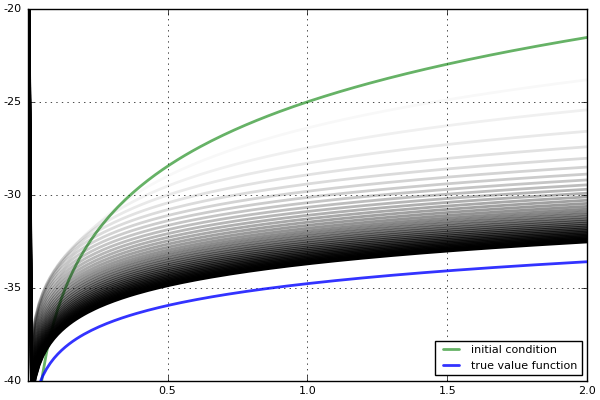

In [55]:
main()

In [65]:
#=
Compute the fixed point of a given operator T, starting from
specified initial condition v.

@author : Spencer Lyon <spencer.lyon@nyu.edu>

@date: 2014-07-05

References
----------

http://quant-econ.net/jl/dp_intro.html
=#


"""
Repeatedly apply a function to search for a fixed point

Approximates `T^∞ v`, where `T` is an operator (function) and `v` is an initial
guess for the fixed point. Will terminate either when `T^{k+1}(v) - T^k v <
err_tol` or `max_iter` iterations has been exceeded.

Provided that `T` is a contraction mapping or similar,  the return value will
be an approximation to the fixed point of `T`.

##### Arguments

* `T`: A function representing the operator `T`
* `v::TV`: The initial condition. An object of type `TV`
* `;err_tol(1e-3)`: Stopping tolerance for iterations
* `;max_iter(50)`: Maximum number of iterations
* `;verbose(2)`: Level of feedback (0 for no output, 1 for warnings only, 2
        for warning and convergence messages during iteration)
* `;print_skip(10)` : if `verbose == 2`, how many iterations to apply between
        print messages

##### Returns
---

* '::TV': The fixed point of the operator `T`. Has type `TV`

##### Example

```julia
using QuantEcon
T(x, μ) = 4.0 * μ * x * (1.0 - x)
x_star = compute_fixed_point(x->T(x, 0.3), 0.4)  # (4μ - 1)/(4μ)
```

"""
function compute_fixed_point{TV}(T::Function, 
                                v::TV; 
                                err_tol=1e-4,
                                max_iter=100, 
                                verbose=2, 
                                print_skip=10)

    if !(verbose in (0, 1, 2))
        throw(ArgumentError("verbose should be 0, 1 or 2"))
    end

    iterate = 0
    err = err_tol + 1
    while iterate < max_iter && err > err_tol
        new_v = T(v)::TV
        iterate += 1
        err = Base.maxabs(new_v - v)
        if verbose == 2
            if iterate % print_skip == 0
                println("Compute iterate $iterate with error $err")
            end
        end
        v = new_v
    end

    if verbose >= 1
        if iterate == max_iter
            warn("max_iter attained in compute_fixed_point")
        elseif verbose == 2
            println("Converged in $iterate steps")
        end
    end

    return v
end

compute_fixed_point (generic function with 1 method)

In [71]:
using PlotlyJS
using Interact
#using QuantEcon

# set up the model
alpha, bet = 0.65, 0.95
gm = GrowthModel() 
w = 5 .* log(gm.grid) .- 25
sigma = get_greedy(gm, w)
bellman(w) = bellman_operator(gm, w)


true_sigma = (1 - alpha*bet) .* collect(gm.grid).^alpha
w = 5 .* gm.u(collect(gm.grid)) .- 25  # Initial condition

# construct the plot with the initial condition above
layout = Layout(yaxis_range=(0, 1), xaxis_range=(0, 2),
                title="Initial condition")

t1 = PlotlyJS.scatter(x=gm.grid, y=true_sigma, marker_color="black", line_opacity=0.8,
             name="true optimal policy")
t2 = PlotlyJS.scatter(x=gm.grid, y=sigma, marker_color="blue", line_opacity=0.8,
             name="approximate optimal policy")

p = PlotlyJS.plot([t1, t2], layout)
display(p)

# now for n=1, 2, ..., 10 compute the policy after n VFI iterations
vf_n = Dict(0=>get_greedy(gm, w))
for n in 1:10
    v_star = compute_fixed_point(bellman, w, max_iter=n, verbose=false)
    vf_n[n] = get_greedy(gm, v_star)
end
#plot!(gm.grid, sigma, color="black", label="initial optimal policy")
#plot!(gm.grid, true_sigma, color="red", label="true optimal policy")


# construct an interactive plot using the data we computed above
@manipulate for n in 1:10
    # update title
    relayout!(p, title="$n value function iterations")
    
    # update the y values on approximation
    restyle!(p, 2; y=(vf_n[n],))
end

Interact.Slider{Int64}(Signal{Int64}(5, nactions=0),"n",5,1:10,true)

nothing

In [60]:
Pkg.add("PlotlyJS")

INFO: Cloning cache of Blink from git://github.com/JunoLab/Blink.jl.git
INFO: Cloning cache of Codecs from git://github.com/dcjones/Codecs.jl.git
INFO: Cloning cache of DocStringExtensions from git://github.com/JuliaDocs/DocStringExtensions.jl.git
INFO: Cloning cache of Hiccup from git://github.com/JunoLab/Hiccup.jl.git
INFO: Cloning cache of HttpCommon from git://github.com/JuliaWeb/HttpCommon.jl.git
INFO: Cloning cache of HttpParser from git://github.com/JuliaWeb/HttpParser.jl.git
INFO: Cloning cache of HttpServer from git://github.com/JuliaWeb/HttpServer.jl.git
INFO: Cloning cache of Lazy from git://github.com/MikeInnes/Lazy.jl.git
INFO: Cloning cache of MbedTLS from git://github.com/JuliaWeb/MbedTLS.jl.git
INFO: Cloning cache of Mustache from git://github.com/jverzani/Mustache.jl.git
INFO: Cloning cache of Mux from git://github.com/JuliaWeb/Mux.jl.git
INFO: Cloning cache of PlotlyJS from git://github.com/spencerlyon2/PlotlyJS.jl.git
INFO: Cloning cache of WebSockets from git://gith

Archive:  /Users/MitsukuniTakuma/.julia/v0.4/HttpParser/deps/downloads/v2.7.1.zip
feae95a3a69f111bc1897b9048d9acbc290992f9
   creating: /Users/MitsukuniTakuma/.julia/v0.4/HttpParser/deps/src/http-parser-2.7.1/
  inflating: /Users/MitsukuniTakuma/.julia/v0.4/HttpParser/deps/src/http-parser-2.7.1/.gitignore  
  inflating: /Users/MitsukuniTakuma/.julia/v0.4/HttpParser/deps/src/http-parser-2.7.1/.mailmap  
  inflating: /Users/MitsukuniTakuma/.julia/v0.4/HttpParser/deps/src/http-parser-2.7.1/.travis.yml  
  inflating: /Users/MitsukuniTakuma/.julia/v0.4/HttpParser/deps/src/http-parser-2.7.1/AUTHORS  
  inflating: /Users/MitsukuniTakuma/.julia/v0.4/HttpParser/deps/src/http-parser-2.7.1/LICENSE-MIT  
  inflating: /Users/MitsukuniTakuma/.julia/v0.4/HttpParser/deps/src/http-parser-2.7.1/Makefile  
  inflating: /Users/MitsukuniTakuma/.julia/v0.4/HttpParser/deps/src/http-parser-2.7.1/README.md  
  inflating: /Users/MitsukuniTakuma/.julia/v0.4/HttpParser/deps/src/http-parser-2.7.1/bench.c  
   crea

100 55365  100 55365    0     0  21410      0  0:00:02  0:00:02 --:--:--   98k
INFO: Done downloading file https://github.com/nodejs/http-parser/archive/v2.7.1.zip
INFO: Attempting to Create directory /Users/MitsukuniTakuma/.julia/v0.4/HttpParser/deps
INFO: Directory /Users/MitsukuniTakuma/.julia/v0.4/HttpParser/deps already created


  inflating: /Users/MitsukuniTakuma/.julia/v0.4/HttpParser/deps/src/http-parser-2.7.1/http_parser.gyp  
  inflating: /Users/MitsukuniTakuma/.julia/v0.4/HttpParser/deps/src/http-parser-2.7.1/http_parser.h  
  inflating: /Users/MitsukuniTakuma/.julia/v0.4/HttpParser/deps/src/http-parser-2.7.1/test.c  


INFO: Attempting to Create directory /Users/MitsukuniTakuma/.julia/v0.4/HttpParser/deps/usr/lib
INFO: Changing Directory to /Users/MitsukuniTakuma/.julia/v0.4/HttpParser/deps/src/http-parser-2.7.1
INFO: Changing Directory to /Users/MitsukuniTakuma/.julia/v0.4/HttpParser/deps/src/http-parser-2.7.1
INFO: Changing Directory to /Users/MitsukuniTakuma/.julia/v0.4/HttpParser/deps/src
INFO: Attempting to Create directory /Users/MitsukuniTakuma/.julia/v0.4/HttpParser/deps/usr/lib
INFO: Directory /Users/MitsukuniTakuma/.julia/v0.4/HttpParser/deps/usr/lib already created
INFO: Changing Directory to /Users/MitsukuniTakuma/.julia/v0.4/HttpParser/deps/src


cc  -I. -DHTTP_PARSER_STRICT=0  -Wall -Wextra -Werror -O3  -fPIC -c http_parser.c -o libhttp_parser.o
cc  -shared -o libhttp_parser.dylib libhttp_parser.o


INFO: Changing Directory to /Users/MitsukuniTakuma/.julia/v0.4/HttpParser/deps/src
INFO: Building Homebrew
sed: .git/GITHUB_HEADERS: No such file or directory
error: unknown option `sort=-version:refname'
usage: git tag [-a|-s|-u <key-id>] [-f] [-m <msg>|-F <file>] <tagname> [<head>]
   or: git tag -d <tagname>...
   or: git tag -l [-n[<num>]] [--contains <commit>] [--points-at <object>] 
		[<pattern>...]
   or: git tag -v <tagname>...

    -l, --list            list tag names
    -n[<n>]               print <n> lines of each tag message
    -d, --delete          delete tags
    -v, --verify          verify tags

Tag creation options
    -a, --annotate        annotated tag, needs a message
    -m, --message <message>
                          tag message
    -F, --file <file>     read message from file
    -s, --sign            annotated and GPG-signed tag
    --cleanup <mode>      how to strip spaces and #comments from message
    -u, --local-user <key id>
                          us

==> Homebrew has enabled anonymous aggregate user behaviour analytics
Read the analytics documentation (and how to opt-out) here:
  https://git.io/brew-analytics
Updated Homebrew from 1995295 to 1e1903e.
Updated 3 taps (homebrew/core, homebrew/science, staticfloat/juliadeps).
==> Cleaning up /Library/Caches/Homebrew...
Removing: /Library/Caches/Homebrew/openssl-1.0.2g.el_capitan.bottle.tar.gz... (3.6M)
==> Migrating /Library/Caches/Homebrew to /Users/MitsukuniTakuma/Library/Caches/Homebrew.jl/...
==> Deleting /Library/Caches/Homebrew...
==> New Formulae
alot
apache-zeppelin
armor
borg
cf4ocl
compose2kube
direvent
dosfstools
dscanner
elvish
eventql
feedgnuplot
fsevents-tools
genext2fs
git-remote-hg
gitversion
gofabric8
grafana
grip
gron
hashcat
hg-fast-export
homebrew/science/fermi-lite
homebrew/science/kaiju
homebrew/science/mothur
hopenpgp-tools
hostess
httpdiff
httpstat
hyper
jxrlib
kube-aws
lean-cli
lego
lepton
libbdplus
libdivecomputer
libngspice
libuninameslist
linkerd
liquigraph


Error: szip-2.1_1 already installed
To install this version, first `brew unlink szip`
==============================[ ERROR: Homebrew ]===============================

LoadError: failed process: Process(`/Users/MitsukuniTakuma/.julia/v0.4/Homebrew/deps/usr/bin/brew install staticfloat/juliatranslated/szip`, ProcessExited(1)) [1]
while loading /Users/MitsukuniTakuma/.julia/v0.4/Homebrew/deps/build.jl, in expression starting on line 2

INFO: Building MbedTLS


==> Installing mbedtls from staticfloat/juliatranslated
==> Downloading https://juliabottles.s3.amazonaws.com/mbedtls-2.3.0_3.el_capitan.bottle.tar.gz
==> Pouring mbedtls-2.3.0_3.el_capitan.bottle.tar.gz
🍺  /Users/MitsukuniTakuma/.julia/v0.4/Homebrew/deps/usr/Cellar/mbedtls/2.3.0_3: 124 files, 2.8M



================================[ BUILD ERRORS ]================================


 - packages with build errors remain installed in /Users/MitsukuniTakuma/.julia/v0.4
 - build the package(s) and all dependencies with `Pkg.build("Homebrew")`
 - build a single package by running its `deps/build.jl` script

INFO: Package database updated
INFO: METADATA is out-of-date — you may not have the latest version of PlotlyJS
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [70]:
Pkg.add("Interact")

INFO: Cloning cache of DataStructures from git://github.com/JuliaLang/DataStructures.jl.git
INFO: Cloning cache of Interact from git://github.com/JuliaLang/Interact.jl.git
INFO: Cloning cache of Reactive from git://github.com/JuliaLang/Reactive.jl.git
INFO: Installing DataStructures v0.4.6
INFO: Installing Interact v0.3.3
INFO: Installing Reactive v0.3.4
INFO: Package database updated
INFO: METADATA is out-of-date — you may not have the latest version of Interact
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [75]:
gm = GrowthModel()
w = 5 .* gm.u(gm.grid) .- 25

discount_factors = [0.9, 0.94, 0.98]
series_length = 25

traces = GenericTrace[]

for bet in discount_factors

    # Compute the optimal policy given the discount factor
    gm.bet = bet
    bellman(w) = bellman_operator(gm, w)
    v_star = compute_fixed_point(bellman, w, max_iter=500, verbose=false)
    sigma = get_greedy(gm, v_star)
    
    # Compute the corresponding time series for capital
    k = Array(Float64, series_length)
    k[1] = 0.1
    
    #sigma_func = scale(interpolate(sigma, BSpline(Linear()), OnGrid()), gm.grid)
    sigma_func = my_lin_interp(gm.grid, sigma)
    
    for t=2:series_length
        k[t] = gm.f(k[t-1]) - sigma_func(k[t-1])
    end
    trace = PlotlyJS.scatter(x=1:series_length, y=k, marker_symbol="circle", 
                    line_width=2, marker_opacity=0.75, 
                    name="β=$(bet)")
    
    push!(traces, trace)
    
end

layout = Layout(xaxis_title="time", 
                yaxis=attr(title="capital", range=(0.1, 0.3)))

PlotlyJS.plot(traces, layout)